In [1]:
%matplotlib widget
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.ticker import ScalarFormatter


from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size

from sklearn.cluster import Birch                       
from sklearn.metrics import silhouette_score

### Single galaxy clustering

Functions


In [4]:
#functions for plotting pre clustering
def min_max(arrays):#finds min and max values from list of arrays
    maxes=[]
    mins=[]
    for array in arrays:
        maxes.append(np.max(array))
        mins.append(np.min(array))
    return max(maxes),min(mins)

def make_string(vel): # turns velocity values into strings, useful for plot labels
    string= str(vel[0])+ ' - '+str(vel[1])+ ' km/s '
    return string

def vis_mom0(array,wcs): #plots moment 0 maps with colourbar
    max,min = min_max(array)
    fig = plt.figure()
    fig.suptitle('Moment 0 Maps')
    
    fig.add_subplot(141,projection=wcs)
    im1=plt.imshow(array[0],vmin=min,vmax=max)
    plt.title(make_string(vels[0]))

    fig.add_subplot(142,projection=wcs)
    im2=plt.imshow(array[1],vmin=min,vmax=max)
    plt.title(make_string(vels[1]))

    fig.add_subplot(143,projection=wcs)
    im3=plt.imshow(array[2],vmin=min,vmax=max)
    plt.title(make_string(vels[2]))
    
    fig.add_subplot(144,projection=wcs)
    im4=plt.imshow(array[3],vmin=min,vmax=max)
    plt.title(make_string(vels[3]))

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = plt.colorbar(im1,cax=cbar_ax)
    cbar.set_label('K km/s')
    plt.show()

def vis_mom1(array,wcs):#plots moment 1 maps with colourbar for each map
    fig = plt.figure()
    fig.suptitle('Moment 1 Maps')
    
    fig.add_subplot(141,projection=wcs)
    im1=plt.imshow(array[0],vmin=300,vmax=2300)
    plt.title(make_string(vels[0]))
    cbar=plt.colorbar()
    cbar.formatter = ScalarFormatter(useMathText=False)
    cbar.ax.set_ylabel('km/s')
    cbar.update_ticks()

    fig.add_subplot(142,projection=wcs)
    im2=plt.imshow(array[1],vmin=2300,vmax=4300)
    plt.title(make_string(vels[1]))
    cbar=plt.colorbar()
    cbar.formatter = ScalarFormatter(useMathText=False)
    cbar.ax.set_ylabel('km/s')
    cbar.update_ticks()

    fig.add_subplot(143,projection=wcs)
    im3=plt.imshow(array[2],vmin=4300,vmax=6300)
    plt.title(make_string(vels[2]))
    cbar=plt.colorbar()
    cbar.formatter = ScalarFormatter(useMathText=False)
    cbar.ax.set_ylabel('km/s')
    cbar.update_ticks()

    fig.add_subplot(144,projection=wcs)
    im4=plt.imshow(array[3],vmin=6300,vmax=8300)
    plt.title(make_string(vels[3]))
    cbar=plt.colorbar()
    cbar.formatter = ScalarFormatter(useMathText=False)
    cbar.ax.set_ylabel('km/s')
    cbar.update_ticks()

    plt.show()

def vis_mom2(array,wcs):
    max=2000
    min= 0
    fig = plt.figure()
    fig.suptitle('Moment 2 Maps')
    
    fig.add_subplot(141,projection=wcs)
    im1=plt.imshow(array[0],vmin=min,vmax=max)
    plt.title(make_string(vels[0]))

    fig.add_subplot(142,projection=wcs)
    im2=plt.imshow(array[1],vmin=min,vmax=max)
    plt.title(make_string(vels[1]))

    fig.add_subplot(143,projection=wcs)
    im3=plt.imshow(array[2],vmin=min,vmax=max)
    plt.title(make_string(vels[2]))
    
    fig.add_subplot(144,projection=wcs)
    im4=plt.imshow(array[3],vmin=min,vmax=max)
    plt.title(make_string(vels[3]))

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = plt.colorbar(im1,cax=cbar_ax)
    cbar.set_label('km/s')
    plt.show()

def plot_filtered(m0,m1,m2,chunk):
    fig = plt.figure()
    fig.suptitle('Masked Moment Maps')
        
    fig.add_subplot(131,projection=wcs)
    im1=plt.imshow(m0)
    plt.title('M0')
    cbar=plt.colorbar()
    cbar.formatter = ScalarFormatter(useMathText=False)
    cbar.ax.set_ylabel('K km/s')
    cbar.update_ticks()

    fig.add_subplot(132,projection=wcs)
    im2=plt.imshow(m1,vmin=vels[chunk][0],vmax=vels[chunk][1])
    plt.title('M1')
    cbar=plt.colorbar()
    cbar.formatter = ScalarFormatter(useMathText=False)
    cbar.ax.set_ylabel('km/s')
    cbar.update_ticks()

    fig.add_subplot(133,projection=wcs)
    im3=plt.imshow(m2,vmin=0,vmax=2000)
    plt.title('M2')
    cbar=plt.colorbar()
    cbar.formatter = ScalarFormatter(useMathText=False)
    cbar.ax.set_ylabel('km/s')
    cbar.update_ticks()
    plt.show()
    
def scatter_maps(m0,m1,m2,z=False):
    plt.figure()
    plt.scatter(m1,m0,c=m2,s=0.6)
    plt.xlabel('Vel km/s')
    plt.ylabel('Intensity K km/s')
    if z==True:   #display z axis
        plt.colorbar(label='Velocity dispersion [km/s]')
    plt.show()

#Clustering Functions
def reconstruct(data, labels, reshape=True):
    """ Reconstructs the clustering labels to be of shape 75,61. If reshape=False, return a flattened array instead"""
    if (len(data.flatten())-len(labels)) != np.sum(np.isnan(data.flatten())):
        raise ValueError("Dimensions do not match")
    ret = []
    for i in data.flatten():
        if np.isnan(i):
            ret.append(np.nan)
        else:
            first, labels = labels[0], labels[1:]
            ret.append(first)
    if reshape:
        return np.array(ret).reshape(75,61)
    return ret

def SI_plot(index,score):
    plt.figure()
    plt.scatter(index,score,color='k',s=0.7)
    plt.xlabel('Number of clusters')
    plt.ylabel('Score')
    plt.title('silhouette index')
    plt.show()

def getCluster(datas, threshold=0.5, n_clusters=None, getData=False, branching_factor=50):
    X = []
    if isinstance(datas, tuple):#check if input data is a tuple
        for i in range(len(datas)):#flatten elements of the tuple and remove NaN values
            X.append( ((datas[i])[~np.isnan(datas[i])]).flatten() )
        Y = np.array(X)#convert to array
        Y = Y.T#transpose for clustering
        #run Birch clustering
        brc = Birch(n_clusters=n_clusters, threshold=threshold, branching_factor=branching_factor).fit(Y)
        labels = brc.predict(Y)#predict cluster labels
        if getData:
            return labels, Y#return labels and data
        return labels#return just labels
    raise ValueError("Input must be of type Tuple. Try to pass it as (x, y, ...) ")

def Scatter2DHighlight(x, y, c=None, title=None, xlabel="", ylabel="", clabel="",  cref=None ):
    """ 2D scatter plot highlighting a specified part. Input it as x: ([all data], [data to highlight]) """
    # fig = plt.figure()
    fig, ax = plt.subplots(figsize=(7.5,6))
    plt.scatter(x[0].flatten(), y[0].flatten(), s=1, c='#CCC', alpha=0.8)
    sc = plt.scatter(x[1], y[1], s=1, vmin=np.min(cref) if cref is not None else None, vmax=np.max(cref) if cref is not None else None, c='blue' if c is None else c)
    plt.xlabel(r"%s" % xlabel)
    plt.ylabel(r"%s" % ylabel)
    if title is not None:
        plt.title(r"%s" % title)
    if isinstance(c, (list, np.ndarray)):
        cbar = plt.colorbar(sc)
        cbar.ax.get_yaxis().labelpad = 15
        cbar.ax.set_ylabel(r"%s" % clabel, rotation=90)

imkw = dict( origin='lower', interpolation='None')

def WorldMap(data,wcs, figsize=(8,6), cmap="viridis", title=None, clabel=None, contour=None, vmin=None, vmax=None, linewidth=1):
    """ Takes an array of datasets [x, y, ...] and plots each dataset individually in WCS coordinates.
    To get contours, input it as contour=([all clusterlabels], [labels to highlight], [colors or getColors(all labels)])"""
    size = len(data)
    fig = plt.figure()

    for i in range(1,size+1,1):
        ax = fig.add_subplot( int((size+1)/2), 1 if size==1 else 2, i, projection=wcs)
        ax.coords
        im = ax.imshow(data[i-1], cmap = cmap, vmin=vmin, vmax=vmax ,  **imkw)
        if isinstance(contour, tuple):
            if isinstance(contour[1], (list, np.ndarray)):
                labs = list(set((contour[1])[~np.isnan(contour[1])]))
                for j in range(len(labs)):
                    lev = np.where(contour[0] == labs[j], labs[j], -1 )
                    ax.contour(lev, colors=('%s' % contour[2][j]) if isinstance(contour[2][j], str) else 
                        ("#%02X%02X%02X%02X" % ( int(contour[2][j][0]*255), int(contour[2][j][1]*255), int(contour[2][j][2]*255), int(contour[2][j][3]*255))),
                        alpha=0.5, linewidths=linewidth)
            if isinstance(contour[1], (int, float, complex)):
                lev = np.where(contour[0]==contour[1], contour[1], -1)
                ax.contour(lev, colors=('white') if len(contour)<3 else
                    "#%02X%02X%02X%02X" % ( int(contour[2][0]*255), int(contour[2][1]*255), int(contour[2][2]*255), int(contour[2][3]*255)),
                    alpha=0.5, linewidths=linewidth)
        ax.grid()
        ax.set_xlabel('Galactic Longitude')
        ax.set_ylabel('Galactic Latitude')
        if isinstance(title, str):
            ax.set_title(r"%s" % title)
        if isinstance(title, (list)):
            ax.set_title(r"%s" % title[i-1])
        cbar = plt.colorbar(im, ax=ax)
        if isinstance(clabel, list):
            cbar.ax.get_yaxis().labelpad = 10
            cbar.ax.set_ylabel(r'%s' % clabel[i-1], rotation=90)
        if isinstance(clabel, str):
            cbar.ax.get_yaxis().labelpad = 10
            cbar.ax.set_ylabel(r'%s' % clabel, rotation=90)
            
class MplColorHelper:
  def __init__(self, cmap_name, start_val, stop_val):
    self.cmap_name = cmap_name
    self.cmap = plt.get_cmap(cmap_name)
    self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
    self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

  def get_rgb(self, val):
    return self.scalarMap.to_rgba(val)

def getColors(labels, cmap_name="jet", convertHex = False):
    lab = list(set(labels[~np.isnan(labels)]))
    low = np.min(lab)
    high= np.max(lab)
    col = MplColorHelper(cmap_name, low, high)
    if convertHex:
        c = col.get_rgb(lab)
        return ["#%02X%02X%02X%02X" % ( int(c[i][0]*255), int(c[i][1]*255), int(c[i][2]*255), int(c[i][3]*255)) for i in range(len(c))]
    return col.get_rgb(lab)

Get maps.

In [2]:
vels = [[300,2300],[2300,4300],[4300,6300],[6300,8300]]#velocity chunks

#import moment maps
c0_m0,c0_m0_h = fits.getdata('gal_cube\chunk0_m0.fits',header=True)
wcs=WCS(c0_m0_h)#only need one wcs, same for all maps
wcs = wcs.dropaxis(2)

c1_m0 = fits.getdata('gal_cube\chunk1_m0.fits')
c2_m0 = fits.getdata('gal_cube\chunk2_m0.fits')
c3_m0 = fits.getdata('gal_cube\chunk3_m0.fits')

c0_m1 = fits.getdata('gal_cube\chunk0_m1.fits')
c1_m1 = fits.getdata('gal_cube\chunk1_m1.fits')
c2_m1 = fits.getdata('gal_cube\chunk2_m1.fits')
c3_m1 = fits.getdata('gal_cube\chunk3_m1.fits')

c0_m2 = fits.getdata('gal_cube\chunk0_m2.fits')
c1_m2 = fits.getdata('gal_cube\chunk1_m2.fits')
c2_m2 = fits.getdata('gal_cube\chunk2_m2.fits')
c3_m2 = fits.getdata('gal_cube\chunk3_m2.fits')

m0s = [c0_m0[0],c1_m0[0],c2_m0[0],c3_m0[0]]#combine maps
m1s = [c0_m1[0],c1_m1[0],c2_m1[0],c3_m1[0]]
m2s = [c0_m2[0],c1_m2[0],c2_m2[0],c3_m2[0]]

Set OBSGEO-B to    50.524830 from OBSGEO-[XYZ].
Set OBSGEO-H to      413.695 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Plot moment maps.

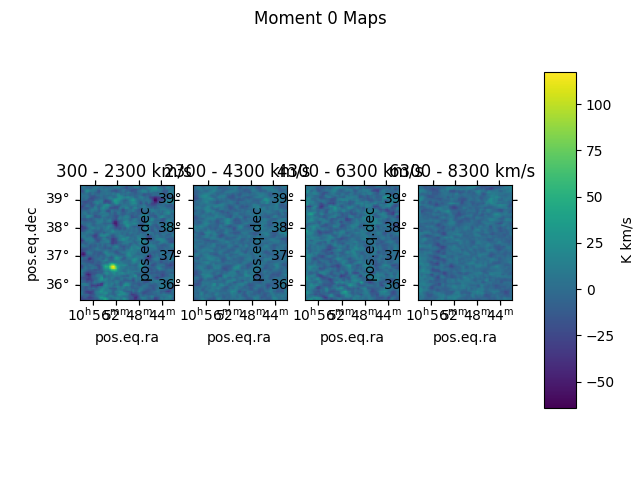

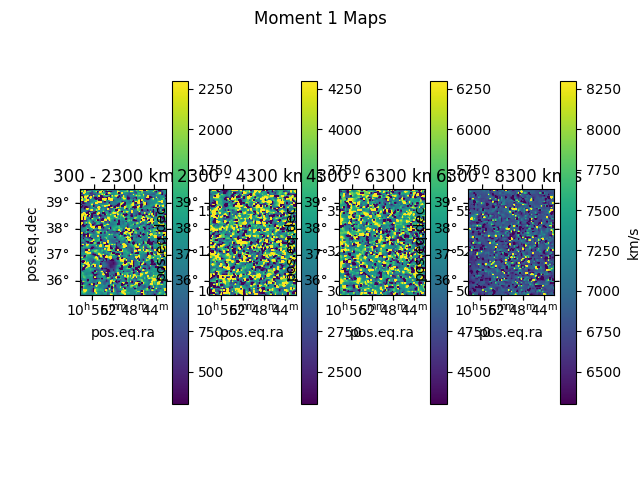

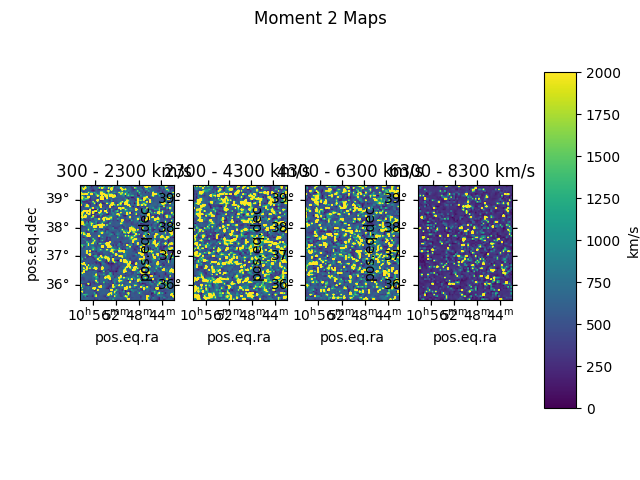

In [5]:
vis_mom0(m0s,wcs)
vis_mom1(m1s,wcs)
vis_mom2(m2s,wcs)

Create masked moment maps.


stitch masked moment maps
